<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/Ising_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ising Model GAN 
Here I create a GAN to generate Ising model configurations. I use a deep convolutional net for both the discriminator and generator.

In [0]:
import tensorflow as tf

%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
#from tensorflow import keras
import glob
import imageio
import PIL
import time

from IPython import display

## Load data
For a GAN, we don't need a validation set, only load the training set

The numpy array saved from simulations was of type ```int```. We need to convert to type ```float32```.

--2020-05-30 16:27:59--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.1’

ising2_conf.dat.1   100%[===================>]  18.18M  38.1MB/s    in 0.5s    

2020-05-30 16:27:59 (38.1 MB/s) - ‘ising2_conf.dat.1’ saved [19060775/19060775]

--2020-05-30 16:28:01--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat.1’

ising2_label.dat.1  100%[===================>]  79.13K  --.-KB/s    in 0.06s   

2020-05-30 16:28:01 (1.39 MB/s) - ‘ising2_label.dat.1’ saved

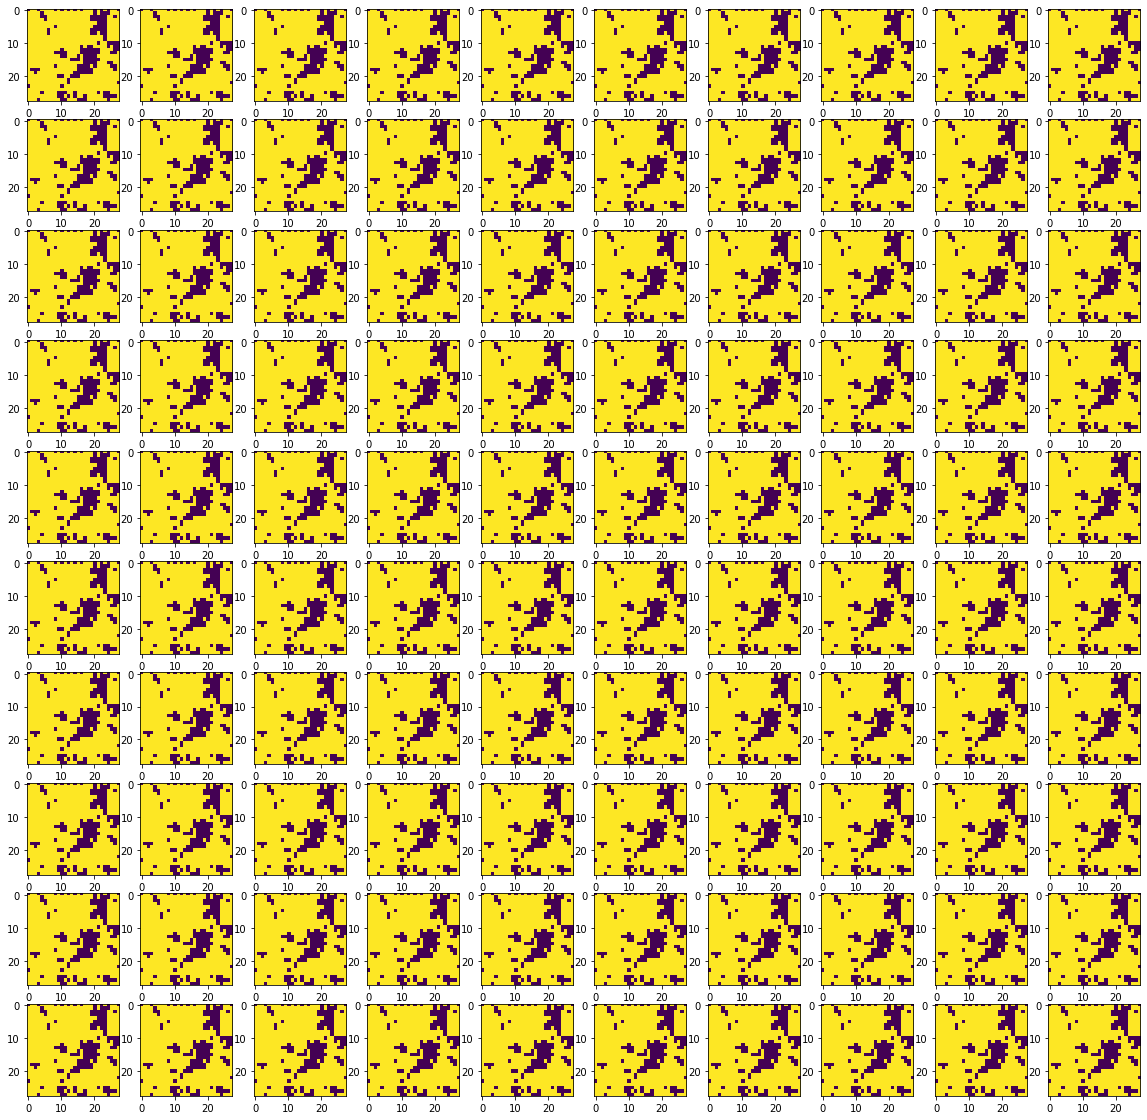

In [0]:


# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat



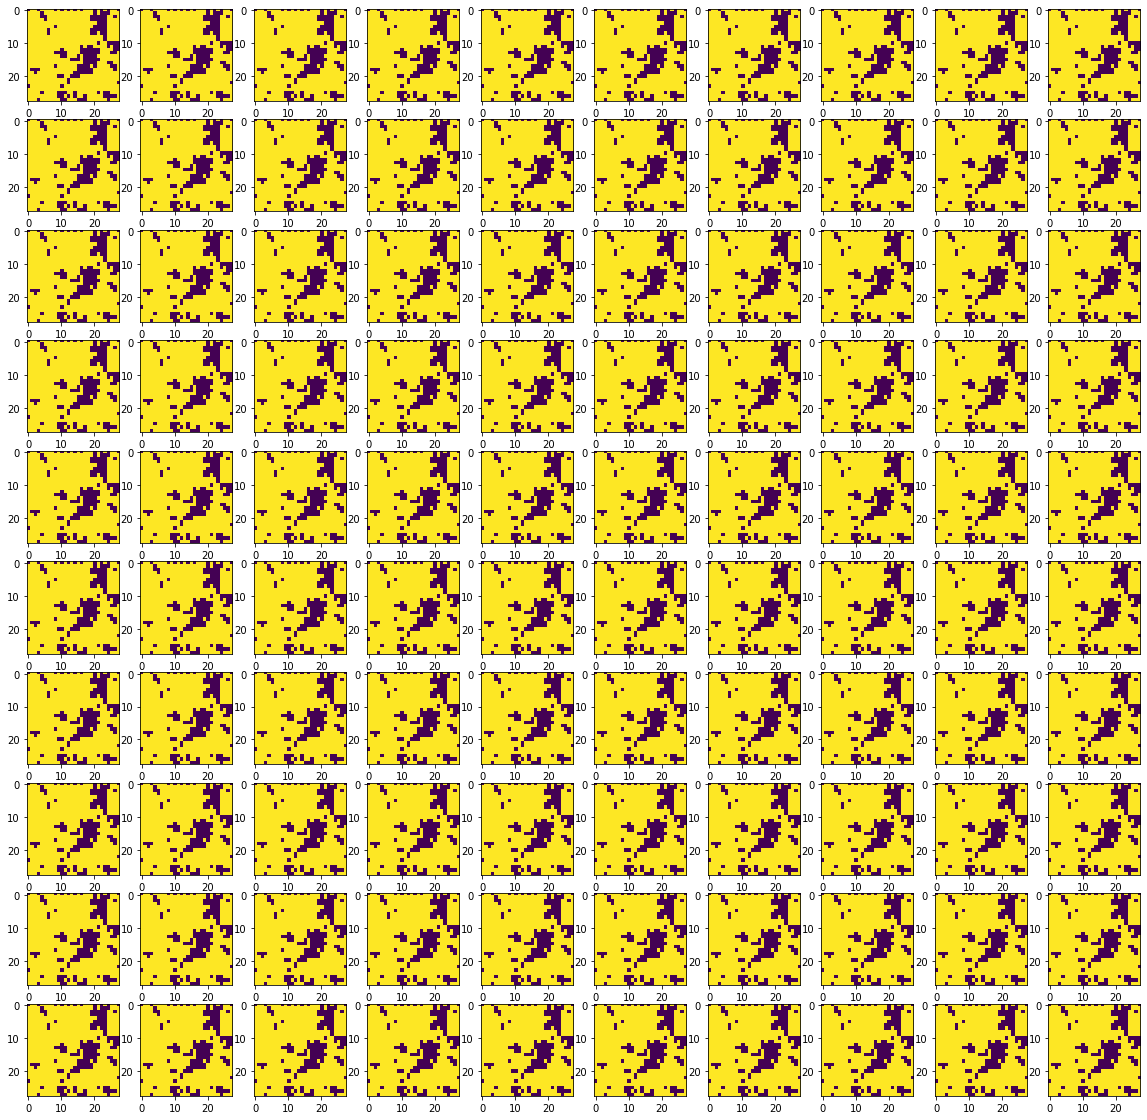

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
labels = np.loadtxt('ising2_label.dat')

#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(-1,28,28,1).astype('float32')

cri_sele = ((labels >= 2) & (labels <= 2.5))
cri_data = data[cri_sele]

n, m = 10, 10
fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(cri_data[n].reshape(28, 28))

train_dataset = tf.data.Dataset.from_tensor_slices(data[:-16, ...])
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(32)

## Define the generator
I use the tf.keras Sequential API to define a net that takes as input a random noise vector of length 100.

The first layer is fully connected.
Then, there are 3 Transverse Convolutional layers, the latter two of which upscale the previous layer output.
The final output is a 20x20 tensor, the same dimensions at the Ising array I am training against.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    # 1. Create a dense layer, and reshape the output to a 7x7x256 layer
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    
    # 2. Creat a "reverse" convolutional layer and reshape the output to 7x7x128
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation=tf.tanh))
    model.summary()
    return model

## Define the discriminator
This net takes a 20x20 input and feeds it to two convolutional layers followed by a single-unit output layer.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    model.summary()

    return model

In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### Define the loss functions

In [0]:
def generator_loss(generated_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [0]:
noise_dim = 100
num_examples_to_generate = 64

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [0]:
BATCH_SIZE = 64
def train_step(images,gen_loss_log,disc_loss_log):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        # Round the generator output
        #generated_images_round = tf.round(generated_images)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  #Add rounding
  predictions = tf.round(model(test_input, training=False))

  fig = plt.figure(figsize=(4,4))
  
  for i in range(16):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
        
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs, gen_loss_log,disc_loss_log):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images,gen_loss_log,disc_loss_log)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
  #  if (epoch + 1) % 15 == 0:
  #    checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

## Train the GAN!

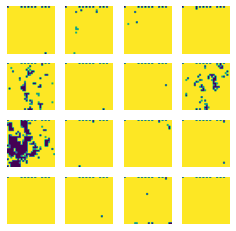

Time taken for epoch 73 is 6.049886465072632 sec


KeyboardInterrupt: ignored

In [0]:
%%time
EPOCHS=100
gen_loss_log=[]
disc_loss_log=[]
tf.get_logger().setLevel('ERROR')
train(train_dataset, EPOCHS,gen_loss_log,disc_loss_log)

## Plot the loss of the generator and discriminator

In [0]:
plt.plot(np.asarray(gen_loss_log))
plt.plot(np.asarray(disc_loss_log))

In [0]:
predictions = generator(random_vector_for_generation, training=False)